In [3]:
# Imports

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import gnnx

from kgcnn.utils.adj import precompute_adjacency_scaled, scaled_adjacency_to_list
from kgcnn.literature.GCN import getmodelGCN

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

## Load the Dataset (Mutagenicity)

In [4]:
from dataloader import load_mutagenicity
mutag_graphs, mutag_labels = load_mutagenicity('./data', filter_invalid_molecules=True)

Preprocessing of the graphs & splitting in training and validation set:

In [5]:
def get_tensor_representation(graphs):
    node_features = []
    node_lengths = []
    edge_weights = []
    edge_lengths = []
    edge_indices = []
    for graph in graphs:
        adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(graph)
        edge_information = scaled_adjacency_to_list(precompute_adjacency_scaled(adjacency_matrix))
        edge_indices.append(edge_information[0])
        edge_weights.append(edge_information[1])
        edge_lengths.append(len(edge_information[0]))
        node_information = np.array([graph.nodes[n]['features'] for n in graph.nodes])
        node_features.append(node_information)
        node_lengths.append(len(node_information))
    node_features = np.vstack(node_features)
    node_features_ragged = tf.RaggedTensor.from_row_lengths(node_features, np.array(node_lengths, dtype=np.int))
    edge_weights = np.expand_dims(np.hstack(edge_weights), axis=-1).astype(np.float32)
    edge_weights_ragged =tf.RaggedTensor.from_row_lengths(edge_weights, np.array(edge_lengths, dtype=np.int))
    edge_indices = np.vstack(edge_indices)
    edge_indices_ragged =tf.RaggedTensor.from_row_lengths(edge_indices, np.array(edge_lengths, dtype=np.int))
    return [node_features_ragged, edge_weights_ragged, edge_indices_ragged]

In [6]:
x_train, val_graphs, y_train, y_val = train_test_split(mutag_graphs, mutag_labels, train_size=0.8, random_state=1)
x_train = get_tensor_representation(x_train)
x_val = get_tensor_representation(val_graphs)
y_train = np.expand_dims(np.array(y_train), axis=-1)
y_val = np.expand_dims(np.array(y_val), axis=-1)

## Training of GNN

/pfs/work7/workspace/scratch/upnub-gnnx-0/conda/envs/gnnx2/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


26/26 [==============================] - 0s 17ms/step - loss: 0.6001 - accuracy: 0.7327
Epoch 2/2
26/26 [==============================] - 0s 18ms/step - loss: 0.6106 - accuracy: 0.6795
Epoch 3/3
26/26 [==============================] - 0s 17ms/step - loss: 0.5438 - accuracy: 0.7475
Epoch 4/4
26/26 [==============================] - 0s 17ms/step - loss: 0.5375 - accuracy: 0.7438
Epoch 5/5
26/26 [==============================] - 1s 27ms/step - loss: 0.5436 - accuracy: 0.7401
Epoch 6/6
26/26 [==============================] - 1s 28ms/step - loss: 0.5657 - accuracy: 0.7079
Epoch 7/7
26/26 [==============================] - 1s 29ms/step - loss: 0.5077 - accuracy: 0.7710
Epoch 8/8
26/26 [==============================] - 0s 17ms/step - loss: 0.5119 - accuracy: 0.7673


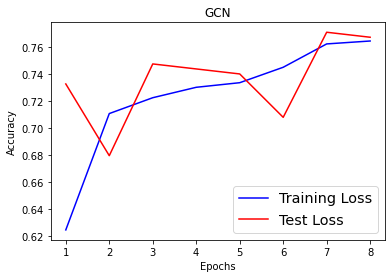

In [7]:
model = getmodelGCN(# Input
                    input_node_shape = [None, 14],
                    input_edge_shape = [None,1],
                    input_state_shape = [1],
                    input_node_vocab = 100,
                    input_edge_vocab = 10,
                    input_state_vocab = 100,
                    input_node_embedd = 64,
                    input_edge_embedd = 64,
                    input_state_embedd = 64,
                    input_type = 'ragged', 
                    # Output
                    output_embedd = 'graph',
                    output_use_bias = [True,True,True,True,True,True,False],
                    output_dim = [25,25,25,25,25,25,1],
                    output_activation = ['relu','relu','relu','relu','relu','relu','sigmoid'],
                    output_kernel_regularizer = [None,None,None,None,None,None,None],
                    output_activity_regularizer = [None,None,None,None,None,None,None],
                    output_bias_regularizer = [None,None,None,None,None,None,None],
                    output_type = 'padded',
                    #Model specific
                    depth = 7,
                    hidden_dim = 100, 
                    use_bias = False,
                    activation = 'relu',
                    graph_labeling = True,
                    is_sorted=True,
                    has_unconnected=False)


learning_rate = 1e-4
epo = 8
epostep = 1
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics = ['accuracy'])

trainlossall = []
testlossall = []
validlossall = []

for iepoch in range(0,epo,epostep):

    hist = model.fit(x_train, y_train, 
              epochs=iepoch+epostep,
              initial_epoch=iepoch,
              batch_size=1,
              verbose=1)

    trainlossall.append(hist.history)
    testlossall.append(model.evaluate(x_val, y_val))    

testlossall = np.array(testlossall)
trainlossall = np.concatenate([x['accuracy'] for x in trainlossall])


#Plot loss vs epochs    
plt.figure()
plt.plot(np.arange(1,len(trainlossall)+1),trainlossall,label='Training Loss',c='blue')
plt.plot(np.arange(epostep,epo+epostep,epostep),testlossall[:,1],label='Test Loss',c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GCN')
plt.legend(loc='lower right',fontsize='x-large')
plt.show()

In [8]:
model.evaluate(x_val, y_val)

26/26 [==============================] - 0s 16ms/step - loss: 0.5119 - accuracy: 0.7673


[0.5118700265884399, 0.7673267126083374]

## Implementation of the `gnnx.GNNInterface`

In [17]:
class ExplainableGCN(gnnx.GNNInterface):
    
    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()
        self.gnn_model = gnn_model
    
    def predict(self, gnn_input, masking_info=None):
        return self.gnn_model(gnn_input, training=False)[0]
        
    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input
                
        masked_edge_input = tf.ragged.map_flat_values(tf.math.multiply, edge_input, edge_mask)
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32), tf.transpose(feature_mask))
        masked_node_feature_input = tf.ragged.map_flat_values(tf.math.multiply, masked_feature_input, node_mask)
        masked_pred = self.gnn_model([masked_node_feature_input, masked_edge_input, edge_index_input], training=training)[0]
        
        return masked_pred
    
    def get_number_of_nodes(self, gnn_input):
        node_input, _ , _ = gnn_input
        return node_input[0].shape[0]
    
    def get_number_of_node_features(self, gnn_input):
        node_input, _ , _ = gnn_input
        return node_input.shape[2]
    
    def get_number_of_edges(self, gnn_input):
        _ , edge_input, _ = gnn_input
        return edge_input[0].shape[0]
    
    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:,0])
        node_relevance = np.array(node_mask[:,0])
        feature_relevance = np.array(feature_mask[:,0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        for i, f in enumerate(features):
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance
    
    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        element_labels = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0,0,0,relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r,g,b,a = plt.get_cmap('tab20')(element)
            node_color_map.append((r,g,b,graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):  
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2,figsize=(8,12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels),explanation[1], color=bar_colors)

Instanciate a Explainable GNN:

In [18]:
explainable_gcn = ExplainableGCN(model)

In [19]:
compile_options = {'loss': 'binary_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=0.2)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.001,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0,
                 'node_mask_norm_ord': 1}

explainer = gnnx.GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

Explain Single Instance and check setup:

CPU times: user 11.3 s, sys: 71.2 ms, total: 11.4 s
Wall time: 12 s


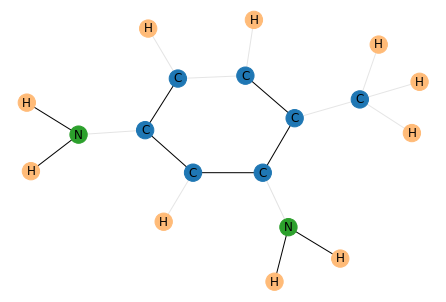

In [20]:
%%time
inspection_result = explainer.explain(get_tensor_representation([val_graphs[786]]), inspection=True)
#inspection_result = explainer.explain(get_tensor_representation([val_graphs[264]]), output_to_explain=tf.Variable([0.]), inspection=True)

explainer.present_explanation(explainer.get_explanation(), threshold=0.5)

Text(0, 0.5, 'GNN output')

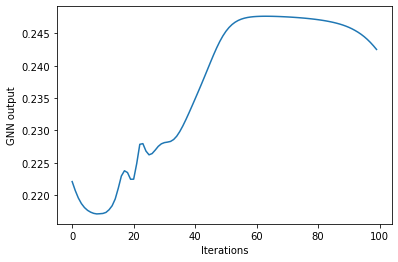

In [21]:
plt.plot(inspection_result['predictions'])
plt.xlabel('Iterations')
plt.ylabel('GNN output')

Text(0, 0.5, 'Total Loss')

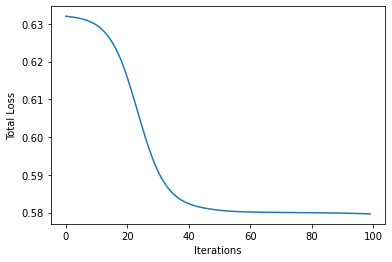

In [22]:
plt.plot(inspection_result['total_loss'])
plt.xlabel('Iterations')
plt.ylabel('Total Loss')

Text(0, 0.5, 'Node Mask Loss')

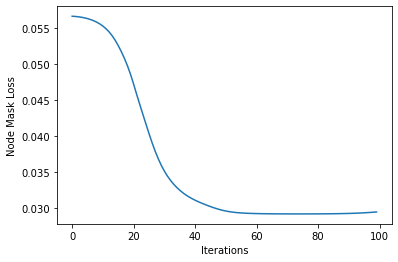

In [23]:
plt.plot(inspection_result['edge_mask_loss'])
plt.xlabel('Iterations')
plt.ylabel('Node Mask Loss')

Sample 200 mutagenic molecules:

In [24]:
pred = model.predict(x_val)[:,0]
sampled_mutagenic_molecules = np.random.choice(np.argwhere(pred < 0.5)[:,0], 200)
sampled_mutagenic_molecules

array([303, 453, 287, 763, 205, 666,  60, 378,  63,  25, 386, 520, 583,
        76, 303, 782, 629, 698, 148, 303, 247, 691, 548, 213, 467, 676,
       778, 639, 750, 791, 670, 695, 175, 212, 207, 520, 392, 558, 282,
       207, 731, 139, 441, 698, 341, 181, 690, 433,  13, 303, 617, 313,
       466,  55, 699, 288, 611, 489, 518, 579,  49, 165, 565, 374,  69,
       165, 567, 233, 205, 342, 666, 271,  59, 137, 599, 504, 468, 331,
       128, 376, 303, 433, 583, 625, 382, 541,  57, 292, 381, 701, 787,
        49, 745, 248, 194, 194, 208, 690, 113, 490, 361, 100, 613, 312,
       378, 113, 128,  33, 171,  20, 437, 766, 739, 324, 660, 340,  35,
       331, 743, 573, 219, 427, 715, 400, 320, 764, 270, 232, 113, 264,
       207, 233, 506, 371,  75, 582, 580, 320, 137,  82, 181, 239, 120,
       617, 185,  44, 702, 183, 490, 626,  63, 698, 101, 291, 580, 283,
       311, 547, 285, 299,  26, 742, 493, 135, 119, 256,  78, 739, 169,
       515, 505, 288, 233, 676, 363, 207, 618, 185, 116, 740, 37

Generate explanations for all those 50 molecules (this will take a while):

In [26]:
explanations = []
for i,mol_index in enumerate(sampled_mutagenic_molecules):
    explainer.explain(get_tensor_representation([val_graphs[mol_index]]))
    print(i, end=',')
    explanations.append(explainer.get_explanation())

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,

We transform the explanation graphs to vectors, in order to apply a cluster algorithm on the explanation vectors:

In [27]:
def explanation_to_vector(explanation):
    graph = explanation[0]
    bond_matrix = np.zeros((14,14))
    for (u, v, relevance) in graph.edges.data('relevance'):
        atom1 = np.argwhere(graph.nodes[u]['features']==1)[0]
        atom2 = np.argwhere(graph.nodes[v]['features']==1)[0]
        bond_matrix[atom1, atom2] += relevance
        bond_matrix[atom2, atom1] += relevance
    bond_vector = bond_matrix[np.triu_indices(bond_matrix.shape[0])]
    bond_vector = bond_vector / np.sum(bond_vector)
    return bond_vector

In [28]:
explanation_vectors = [explanation_to_vector(expl) for expl in explanations]

A dendogram of the explanation vectors:

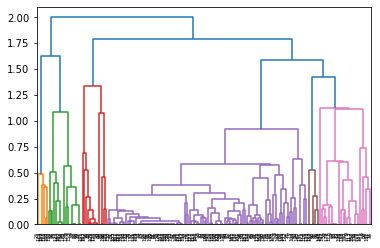

In [29]:
linked = linkage(explanation_vectors, 'complete', metric='cityblock')
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [30]:
num_clusters = 7

Print one representative graph explanation for each cluster:

(31, 105)


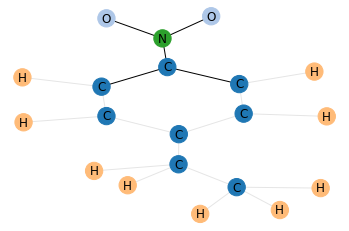

(20, 105)


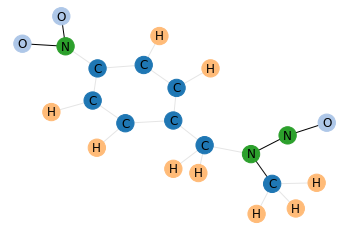

(5, 105)


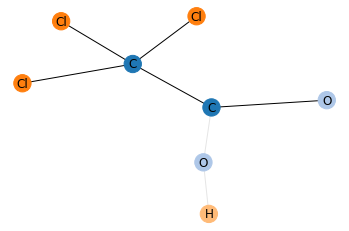

(7, 105)


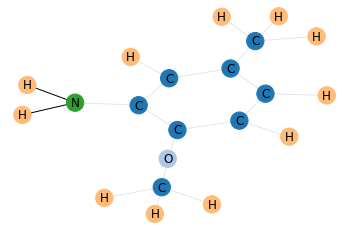

(120, 105)


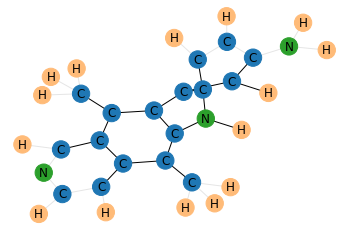

(7, 105)


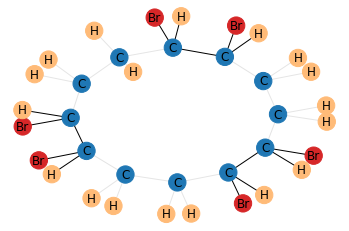

(10, 105)


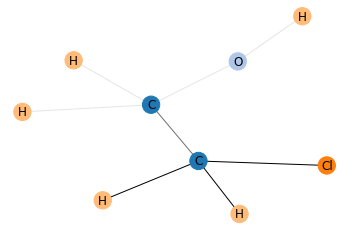

In [31]:
db = AgglomerativeClustering(n_clusters=num_clusters, affinity='manhattan', linkage='complete').fit(explanation_vectors)
vector_clusters = []
explanation_clusters = []
for cluster_ind in range(num_clusters):
    vector_cluster = np.array([explanation_vectors[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]])
    vector_clusters.append(vector_cluster)
    explanation_cluster = [explanations[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]]
    explanation_clusters.append(explanation_cluster)
    cluster_mean = np.mean(vector_cluster, axis=0)
    dist = cdist(np.array([cluster_mean]), vector_cluster)[0]
    print(vector_cluster.shape)
    ax = plt.subplot()
    explainer.present_explanation(explanation_cluster[np.argmin(dist)])
    plt.show()